#### Written by Alessandro Tuniz

This raw Notebook reproduces parts of Fig. 3 and Fig. 4 of


"Influence of non-Hermitian mode topology on refractive index sensing with plasmonic waveguides" 
By Alessandro Tuniz, Markus A. Schmidt & Boris T. Kuhlmey 
Photonics Research Vol. 10, No. 3, 719--730 (2022) 
https://doi.org/10.1364/PRJ.449067

For research purposes only.

Please cite the above paper if this code was useful for your research.

Creative Commons License (LICENSE-CC-BY-NC-SA).

**Paper Abstract:** 
We evaluate the sensing properties of plasmonic waveguide sensors by calculating their resonant
transmission spectra in different regions of the non-Hermitian eigenmode space.
We elucidate the pitfalls of using modal dispersion calculations in isolation to predict plasmonic
sensor performance, which we address by using a simple model accounting for eigenmode excitation
and propagation. Our transmission calculations show that resonant wavelength and spectral width crucially
depend on the length of the sensing region, so that no single criterion obtained from modal 
dispersion calculations alone can be used as a proxy for sensitivity. Furthermore, 
we find that the optimal detection limits occur where directional coupling is supported, 
where the narrowest spectra occur. Such narrow spectral features can only be measured by filtering 
out all higher-order modes at the output, e.g., via a single-mode waveguide. Our calculations 
also confirm a characteristic square root dependence of the eigenmode splitting with respect 
to the permittivity perturbation at the exceptional point, which we show can be identified through 
the sensor beat length at resonance. This work provides a convenient framework for designing and 
characterizing plasmonic waveguide sensors when comparing with experimental measurements.

#### Check the version

In [31]:
import numpy as np
import matplotlib
import scipy as sp
import IPython

print(f'Numpy {np.__version__}')
print(f'Matplotlib {matplotlib.__version__}')
print(f'SciPy {sp.__version__}')
print(f'IPython {IPython.__version__}')


Numpy 1.18.5
Matplotlib 3.2.2
SciPy 1.5.0
IPython 7.16.1


#### Import python libraries and define functions


In [32]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io as sio
import scipy as sp
from scipy.optimize import fsolve
from mpmath import mp
from IPython.display import clear_output
import os
import sys
import time
from IPython.display import display, clear_output

# some global variables
e0 = 8.85418787162e-12 # permittivity of free space
c0 = 299792458 # speed of light

# function for numerical derivative (not really needed here, but sometimes useful)

def derivative(xx,yy):
    dxx = (xx[2]-xx[0])
    dyy_dxx =  np.zeros(xx.size-2)+0*1j
    for k in range(1,xx.size-1):
        dyy_dxx[k-1] = (yy[k+1]-yy[k-1])/dxx
    yy0 = (4*yy[1]-yy[2]-3*yy[0])/(dxx)
    yyf = (4*yy[-1-1]-yy[-1-2]-3*yy[-1])/(-dxx)
    dyy_dxx = np.hstack([yy0, dyy_dxx, yyf])
    return dyy_dxx


#### Define material properties


In [33]:
# gold, Drude model, from
# A. D. Rakić, A. B. Djurišic, J. M. Elazar, and M. L. Majewski. Optical properties of metallic films for vertical-cavity optoelectronic devices, Appl. Opt. 37, 5271-5283 (1998)

def eps_gold_drude(lm): 
    w = 1239.8/(lm/1e-9) # convert from wavelength to eV
    wp = 9.03
    f0 = 0.760
    Op = np.sqrt(f0)*wp
    G0 = 0.053
    f1 = 0.024
    G1 = 0.241
    w1 = 0.415
    f2 = 0.010
    G2 = 0.345
    w2 = 0.830
    f3 = 0.071
    G3 = 0.870
    w3 = 2.969
    f4 = 0.601
    G4 = 2.494
    w4 = 4.304
    f5 = 4.384
    G5 = 2.214
    w5 = 13.32
    er1 = 1-Op**2/(w*(w-1j*G0))
    er2 = f1*wp**2/((w1**2-w**2)+1j*w*G1) + f2*wp**2/((w2**2-w**2)+1j*w*G2) + f3*wp**2/((w3**2-w**2)+1j*w*G3) + f4*wp**2/((w4**2-w**2)+1j*w*G4) + f5*wp**2/((w5**2-w**2)+1j*w*G5)    
    er_drude = np.conj(er1+er2)
    return er_drude

# silica, from
# I. H. Malitson. Interspecimen comparison of the refractive index of fused silica, J. Opt. Soc. Am. 55, 1205-1208 (1965)
def eps_silica(lm):
    LM = lm*1e6   # wavelength [um]
    B1 = 0.6961663
    C1 = 0.0684043
    B2 = 0.4079426
    C2 = 0.1162414
    B3 = 0.8974794
    C3 = 9.896161
    eps_SiO2 = 1 + B1*LM**2/(LM**2-C1**2) + B2*LM**2/(LM**2-C2**2) + B3*LM**2./(LM**2-C3**2)
    return eps_SiO2


In [34]:
# waveguide functions
# polarization: TM

# slabs of thickness di and material permittivity $e_i$ are distributed along $x$ as follows:

# thickness and permittivity:    

#  infinite  | d1 | d2 | d3 | infinite 
# -----------|----|----|----|----------
#  e1        | e2 | e3 | e4 | e5       
# 
# ---------------------------------------> x 

# y is "out of plane" (1D mode, so it's infinite): this is a TM mode, so we have only Hy 
# x is perpendicular to the interface: this is TM mode, se Ex is the dominant electric field component
# z is the direction of propagation: this is a TM mode, so we have an Ez component

In [35]:
# matrix to solve from simple slab model 
def disp_slab_5_mat(neff,*data):
    k0, e1, e2, e3, e4, e5, d1, d2, d3 = data
    g1 = k0*np.sqrt(neff**2-e1)
    k2 = k0*np.sqrt(e2-neff**2)
    k3 = k0*np.sqrt(e3-neff**2)
    k4 = k0*np.sqrt(e4-neff**2)
    g5 = k0*np.sqrt(neff**2-e5)
    dispersion_matrix = np.matrix([[1, -1, -1, 0, 0, 0, 0, 0],
                                   [0, np.exp(1j*k2*d1), np.exp(-1j*k2*d1), -np.exp(1j*k3*d1), -np.exp(-1j*k3*d1), 0, 0, 0],
                                   [0, 0, 0, np.exp(1j*k3*(d1+d2)), np.exp(-1j*k3*(d1+d2)), -np.exp(1j*k4*(d1+d2)), -np.exp(-1j*k4*(d1+d2)), 0],
                                   [0, 0, 0, 0, 0, np.exp(1j*k4*(d1+d2+d3)), np.exp(-1j*k4*(d1+d2+d3)),-np.exp(-g5*(d1+d2+d3))],
                                   [-1j*g1/(k0*c0*e0*e1), -k2/(k0*c0*e0*e2), k2/(k0*c0*e0*e2), 0, 0, 0, 0, 0],
                                   [0, k2/(k0*c0*e0*e2)*np.exp(1j*k2*d1), -k2/(k0*c0*e0*e2)*np.exp(-1j*k2*d1), -k3/(k0*c0*e0*e3)*np.exp(1j*k3*d1), k3/(k0*c0*e0*e3)*np.exp(-1j*k3*d1),0,0,0],
                                   [0, 0, 0, k3/(k0*c0*e0*e3)*np.exp(1j*k3*(d1+d2)), -k3/(k0*c0*e0*e3)*np.exp(-1j*k3*(d1+d2)), -k4/(k0*c0*e0*e4)*np.exp(1j*k4*(d1+d2)), k4/(k0*c0*e0*e4)*np.exp(-1j*k4*(d1+d2)), 0],
                                   [0, 0, 0, 0, 0, k4/(k0*c0*e0*e4)*np.exp(1j*k4*(d1+d2+d3)), -k4/(k0*c0*e0*e4)*np.exp(-1j*k4*(d1+d2+d3)),-1j*g5*np.exp(-g5*(d1+d2+d3))/(k0*c0*e0*e5)]])
    out = dispersion_matrix
    return out

# dispersion relation comes from determinant of above matrix
def disp_slab_5(neff,*data):
    k0, e1, e2, e3, e4, e5, d1, d2, d3 = data
    out = np.linalg.det(disp_slab_5_mat(neff,*data))
    return out

# function to use for finding zero of dispersion relation numerically
def disp_slab_5_solve(neff_array,*data):
    neff = neff_array[0]+1j*neff_array[1]
    det_dispersion_matrix = disp_slab_5(neff,*data)
    out = np.array((np.real(det_dispersion_matrix),np.imag(det_dispersion_matrix)))
    return out

# function to obtain the coefficients using Cramer's rule
def coefficient(M,l,n):
    M=np.matrix(M)
    M_list=np.array(M.tolist())
    detM = np.linalg.det(M)
    l = mp.matrix(l)
    l_list = np.array(l.tolist())
    M_list[:,n]=l_list[:,0]
    out = np.linalg.det(np.matrix(M_list))/detM
    return out

# define a function for permittivity distributions
def epsilon_distribution(e1,e2,e3,e4,e5,d1,d2,d3,x):
    e = np.zeros(x.size)+0*1j
    e[np.where(x<0)] = e1
    e[np.where(np.logical_and(x>=0, x<=d1))] = e2
    e[np.where(np.logical_and(x>d1, x<d1+d2))] = e3
    e[np.where(np.logical_and(x>=d1+d2, x<=0+d1+d2+d3))] = e4
    e[np.where(x>d1+d2+d3)] = e5
    return e

def calculate_fields(d1,d2,d3,dx,neff0,k0,e1,e2,e3,e4,e5):
    w = k0*c0
# get the coefficients from the neff, Cramer's rule... start from A=1 to get the rest, renormalize later.
    dispersion_matrix = disp_slab_5_mat(neff0,k0, e1, e2, e3, e4, e5, d1, d2, d3)
    dispersion_matrix_list = np.array(dispersion_matrix.tolist())
    dispersion_matrix_list_red=np.delete(np.delete(dispersion_matrix_list, 0, 1),7,0) # reduce matrix
    l = -dispersion_matrix_list[0:7,0]
    A = 1
    B = coefficient(dispersion_matrix_list_red,l,0)
    C = coefficient(dispersion_matrix_list_red,l,1)
    D = coefficient(dispersion_matrix_list_red,l,2)
    E = coefficient(dispersion_matrix_list_red,l,3)
    F = coefficient(dispersion_matrix_list_red,l,4)
    G = coefficient(dispersion_matrix_list_red,l,5)
    H = coefficient(dispersion_matrix_list_red,l,6)
    
#   calculate the ki...
    g1 = k0*np.sqrt(neff0**2-e1)
    k2 = k0*np.sqrt(e2-neff0**2)
    k3 = k0*np.sqrt(e3-neff0**2)
    k4 = k0*np.sqrt(e4-neff0**2)
    g5 = k0*np.sqrt(neff0**2-e5)
#   field is distributed in x...
    x1 = np.arange(-3e-6,0-dx,dx)
    x2 = np.arange(0,d1,dx)
    x3 = np.arange(d1+dx,d1+d2,dx)
    x4 = np.arange(d1+d2+dx,d1+d2+d3,dx)
    x5 = np.arange(d1+d2+d3+dx,(d1+d2+d3)+5e-6,dx)
    x_tot =  (np.concatenate([x1,x2,x3,x4,x5]))

#   magnetic field in y
    Hy1 = A*np.exp(g1*x1)
    Hy2 = B*np.exp(1j*k2*x2)+C*np.exp(-1j*k2*x2)
    Hy3 = D*np.exp(1j*k3*x3)+E*np.exp(-1j*k3*x3)
    Hy4 = F*np.exp(1j*k4*x4)+G*np.exp(-1j*k4*x4)
    Hy5 = H*np.exp(-g5*x5)
    Hy_tot = (np.concatenate([Hy1,Hy2,Hy3,Hy4,Hy5]))
    
    # define permittivity distribution
    e = epsilon_distribution(e1,e2,e3,e4,e5,d1,d2,d3,x_tot)
    
    # electric field Ex
    b=neff0*k0
    Ex_tot = -b/w/e/e0*Hy_tot
    # normalize - Eq. (7)
    norm = 0.5*(np.trapz(-Ex_tot*(Hy_tot),x=x_tot))

    # make sure all fields consistent
    Hy_tot = Hy_tot/np.sqrt(norm)
    Ex_tot = Ex_tot/np.sqrt(norm)

    # including Ez for completeness, although it doesn't get used...
    dHy_dx = derivative(x_tot,Hy_tot)
    Ez_tot = -1j/w/e/e0*(dHy_dx)
    return x_tot, Hy_tot, Ex_tot, Ez_tot

# finding the modes and fields in one function
def mode_solver(lm,neff_guess,e1,e2,e3,e4,e5,d1,d2,d3,dx):
    k0 = 2*np.pi/lm  
    neff_fsolve = fsolve(disp_slab_5_solve,np.array([np.real(neff_guess),np.imag(neff_guess)+1e-5]),args=(k0, e1, e2, e3, e4, e5, d1, d2, d3),xtol = 1e-100)
    neff = neff_fsolve[0]+1j*neff_fsolve[1]
    x, Hy, Ex, Ez = calculate_fields(d1,d2,d3,dx,neff,k0,e1,e2,e3,e4,e5)
    return x, Hy, Ex, Ez, neff


#### Which non-Hermitian regime do you want to be in? 

Change n_analyte to see the two different regimes: 

"Effective" PT Broken (EPTB): n_analyte = 1.32

"Effective" PT Broken (EPTS): n_analyte = 1.36


In [70]:
# n_analyte = 1.32 # analyte index for EPTB regime

n_analyte = 1.36 # analyte index for EPTS regime

#### Calculate / effective index and fields for the first wavelength

Do this first to for the hybrid/isolated materials,
to get the guess values at the first wavelength of the relevant mode you're looking for


In [71]:
N_points = 100 # number of points in wavelength range - keeping it small for speed
lm_range = np.linspace(500e-9,800e-9,N_points)  # wavelength range

lm = lm_range[0]
k0 = 2*np.pi/lm
w = k0*c0

# define material distribution
e1 = n_analyte**2
e2 = eps_silica(lm)
e3 = eps_gold_drude(lm)**2
e4 = n_analyte**2
e5 = n_analyte**2

# define slab thicknesses
d1 = 1.95e-6 # silica
d2 =  30e-9  # gold
d3 = 0.5e-6 # this number doesn't matter here

# range of real and imaginary index where to look for mode
neffr = np.linspace(1.3,1.5,100)
neffi = np.linspace(0,0.02,100)
neffR, neffI = np.meshgrid(neffr,neffi)
neff = neffR+neffI*1j
dispersion_function=np.zeros([neffr.size,neffi.size])+0*1j

#  calculate the dispersion relation in a region of interest, we will look for the zeros
for kx in range(0,neffr.size):
    clear_output(wait=True)
    print(f'{float(kx+1)/float(neffr.size)*100}% complete')
    sys.stdout.flush()
    for ky in range(0,neffi.size):
        dispersion_function[kx,ky] = disp_slab_5(neff[kx,ky],k0, e1, e2, e3, e4, e5, d1, d2, d3)


100.0% complete


#### Plot dispersion function, we look for zeros to find modes (blue regions)


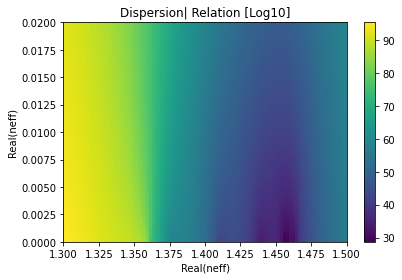

In [72]:
plt.figure()
plt.pcolor(neffR,neffI,10*np.log10(np.abs(dispersion_function)))
plt.xlabel('Real(neff)')
plt.ylabel('Real(neff)')
plt.title('Dispersion| Relation [Log10]')
plt.colorbar()
plt.tight_layout()
plt.show()

#### Show an example mode 

Starting from an appropriate guess value


C:\Users\atun9737\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)


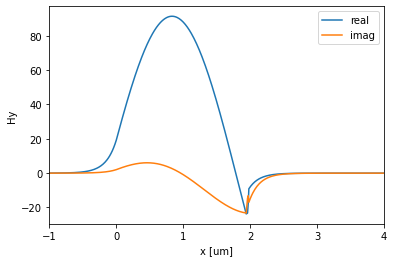

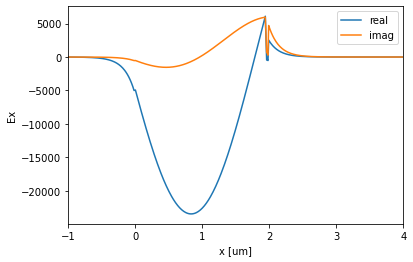

In [73]:
neff_guess = 1.47+0.01*1j
data = (k0, e1, e2, e3, e4, e5, d1, d2, d3)
neff0_fsolve = fsolve(disp_slab_5_solve,np.array((np.real(neff_guess),np.imag(neff_guess))),args=data,xtol = 1e-200)
neff0 = neff0_fsolve[0]+1j*neff0_fsolve[1]

# spatial resolution
dx = 10e-9
x, Hy, Ex, Ez = calculate_fields(d1,d2,d3,dx,neff0,k0,e1,e2,e3,e4,e5)

plt.figure()
plt.plot(x/1e-6,np.real(Hy),label='real')
plt.plot(x/1e-6,np.imag(Hy),label='imag')
plt.xlim([-1, 4])
plt.legend()
plt.xlabel('x [um]')
plt.ylabel('Hy')
plt.show()

plt.figure()
plt.plot(x/1e-6,np.real(Ex),label='real')
plt.plot(x/1e-6,np.imag(Ex),label='imag')
plt.xlim([-1, 4])
plt.legend()
plt.xlabel('x [um]')
plt.ylabel('Ex')
plt.show()





#### Define and plot modes at the first wavelength of the array


C:\Users\atun9737\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)


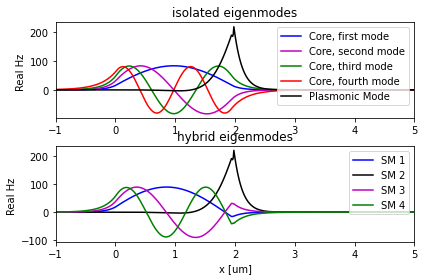

In [74]:
# create a mesh for wavelength and space

LM, X = np.meshgrid(lm_range,x)

# pre-allocate variables

# isolated Eigenmodes
neff_0 = np.zeros(lm_range.shape)+0*1j   # isolated dielectric mode 1
neff_0_2 = np.zeros(lm_range.shape)+0*1j # isolated dielectric mode 2 
neff_0_3 = np.zeros(lm_range.shape)+0*1j # isolated dielectric mode 3
neff_0_4 = np.zeros(lm_range.shape)+0*1j # isolated dielectric mode 4
neff_s = np.zeros(lm_range.shape)+0*1j   # isolated plasmonic mode 

# Hybrid Eigenmodes
neff_1 = np.zeros(lm_range.shape)+0*1j   # hybrid dielectric mode 1
neff_2 = np.zeros(lm_range.shape)+0*1j   # hybrid dielectric mode 2
neff_3 = np.zeros(lm_range.shape)+0*1j   # hybrid dielectric mode 3
neff_4 = np.zeros(lm_range.shape)+0*1j   # hybrid dielectric mode 4

# pre-allocate all relevant fields
# isolated Eigenmodes
Hy_0 = np.zeros(LM.shape)+0*1j
Ex_0 = np.zeros(LM.shape)+0*1j
Hy_0_2 = np.zeros(LM.shape)+0*1j
Hy_0_3 = np.zeros(LM.shape)+0*1j
Hy_0_4 = np.zeros(LM.shape)+0*1j
Ex_0_2 = np.zeros(LM.shape)+0*1j
Ex_0_3 = np.zeros(LM.shape)+0*1j
Ex_0_4 = np.zeros(LM.shape)+0*1j
Hy_s = np.zeros(LM.shape)+0*1j
Ex_s = np.zeros(LM.shape)+0*1j

# Hybrid Eigenmodes
Hy_1 = np.zeros(LM.shape)+0*1j
Ex_1 = np.zeros(LM.shape)+0*1j
Hy_2 = np.zeros(LM.shape)+0*1j
Ex_2 = np.zeros(LM.shape)+0*1j
Hy_3 = np.zeros(LM.shape)+0*1j
Ex_3 = np.zeros(LM.shape)+0*1j
Hy_4 = np.zeros(LM.shape)+0*1j
Ex_4 = np.zeros(LM.shape)+0*1j

# material distribution, isolated modes, see Fig. 3
e1 = n_analyte**2
e2 = eps_silica(lm)
e3 = n_analyte**2
e4 = n_analyte**2
e5 = n_analyte**2

neff_0_guess = 1.457+1e-10*1j
x, Hy_0 [:,0], Ex_0[:,0], Ez_0, neff_0[0] = mode_solver(lm_range[0],neff_0_guess,e1,e2,e3,e4,e5,d1,d2,d3,dx)

neff_0_2_guess = 1.44485342585946874294+1e-10*1j
x, Hy_0_2[:,0], Ex_0[:,0], Ez_0_2, neff_0_2[0] = mode_solver(lm_range[0],neff_0_2_guess,e1,e2,e3,e4,e5,d1,d2,d3,dx)

neff_0_3_guess = 1.42336902798776132606+1e-10*1j
x, Hy_0_3[:,0], Ex_0[:,0], Ez_0_3, neff_0_3[0] = mode_solver(lm_range[0],neff_0_3_guess,e1,e2,e3,e4,e5,d1,d2,d3,dx)

neff_0_4_guess = 1.40+1e-10*1j
x, Hy_0_4[:,0], Ex_0[:,0], Ez_0_4, neff_0_4[0] = mode_solver(lm_range[0],neff_0_4_guess,e1,e2,e3,e4,e5,d1,d2,d3,dx)

# material distribution, plasmonic mode, see Fig. 3
e1 = eps_silica(lm)
e2 = eps_silica(lm)
e3 = eps_gold_drude(lm)
e4 = n_analyte**2
e5 = n_analyte**2
neff_s_guess = 1.463924278673932173332+0.05768463218076293086*1j
x, Hy_s[:,0], Ex_0[:,0], Ez_s, neff_s[0] = mode_solver(lm_range[0],neff_s_guess,e1,e2,e3,e4,e5,d1,d2,d3,dx)

# material distribution, hybrid modes, see Fig. 3
e1 = n_analyte**2
e2 = eps_silica(lm)
e3 = eps_gold_drude(lm)
e4 = n_analyte**2
e5 = n_analyte**2

# Hybrid mode 1 - fundamental dielectric-like to begin with
neff_1_guess = 1.45+1e-10*1j
x, Hy_1[:,0], Ex_1[:,0], Ez_1, neff_1[0] = mode_solver(lm_range[0],neff_1_guess,e1,e2,e3,e4,e5,d1,d2,d3,dx)
# Hybrid mode 2 - plasmonic-like to begin with
neff_2_guess = 1.463924278673932173332+0.05768463218076293086*1j
x, Hy_2[:,0], Ex_2[:,0], Ez_2, neff_2[0] = mode_solver(lm_range[0],neff_2_guess,e1,e2,e3,e4,e5,d1,d2,d3,dx)
# other modes below
# Hybrid mode 3
neff_3_guess =  1.44+1e-10*1j
x, Hy_3[:,0], Ex_3[:,0], Ez_3, neff_3[0] = mode_solver(lm_range[0],neff_3_guess,e1,e2,e3,e4,e5,d1,d2,d3,dx)
# Hybrid mode 4
neff_4_guess =  1.40+1e-10*1j
x, Hy_4[:,0], Ex_4[:,0], Ez_4, neff_4[0] = mode_solver(lm_range[0],neff_4_guess,e1,e2,e3,e4,e5,d1,d2,d3,dx)

plt.figure()
plt.subplot(2,1,1)
plt.plot(x/1e-6,np.real(Hy_0[:,0]),'-b',label='Core, first mode')
plt.plot(x/1e-6,np.real(Hy_0_2[:,0]),'-m',label='Core, second mode')
plt.plot(x/1e-6,np.real(Hy_0_3[:,0]),'-g',label='Core, third mode')
plt.plot(x/1e-6,np.real(Hy_0_4[:,0]),'-r',label='Core, fourth mode')
plt.plot(x/1e-6,np.real(Hy_s[:,0]),'-k',label='Plasmonic Mode')
plt.xlim([-1, 5])
plt.ylabel('Real Hz ')
plt.title('isolated eigenmodes')
plt.legend(loc=1)
plt.subplot(2,1,2)
plt.plot(x/1e-6,np.real(Hy_1[:,0]),'-b',label='SM 1')
plt.plot(x/1e-6,np.real(Hy_2[:,0]),'-k',label='SM 2')
plt.plot(x/1e-6,np.real(Hy_3[:,0]),'-m',label='SM 3')
plt.plot(x/1e-6,np.real(Hy_4[:,0]),'-g',label='SM 4')
plt.xlim([-1, 5])
plt.xlabel('x [um]')
plt.ylabel('Real Hz ')
plt.tight_layout()
plt.title('hybrid eigenmodes')
plt.legend(loc=1)
plt.show()


#### Loop over all wavelengths
Note: we are not storing the z-component of the fields (not used)


In [75]:
for kn in range(1,lm_range.size):
    clear_output(wait=True)
    print(f'{float(kn+1)/float(lm_range.size)*100}% complete')

    # update wavelength here to include everywhere below
    lm = lm_range[kn]
    k0 = 2*np.pi/lm
    w = k0*c0

    ##### isolated modes
    
    e1 = n_analyte**2
    e2 = eps_silica(lm)
    e3 = n_analyte**2
    e4 = n_analyte**2
    e5 = n_analyte**2

    x, Hy_0[:,kn], Ex_0[:,kn], Ez_0, neff_0[kn] = mode_solver(lm_range[kn],neff_0[kn-1],e1,e2,e3,e4,e5,d1,d2,d3,dx)
    x, Hy_0_2[:,kn], Ex_0_2[:,kn], Ez_0_2, neff_0_2[kn] = mode_solver(lm_range[kn],neff_0_2[kn-1],e1,e2,e3,e4,e5,d1,d2,d3,dx)
    x, Hy_0_3[:,kn], Ex_0_3[:,kn], Ez_0_3, neff_0_3[kn] = mode_solver(lm_range[kn],neff_0_3[kn-1],e1,e2,e3,e4,e5,d1,d2,d3,dx)
    x, Hy_0_4[:,kn], Ex_0_4[:,kn], Ez_0_4, neff_0_4[kn] = mode_solver(lm_range[kn],neff_0_4[kn-1],e1,e2,e3,e4,e5,d1,d2,d3,dx)

    ##### plasmonic mode
    
    e1 = eps_silica(lm)
    e2 = eps_silica(lm)
    e3 = eps_gold_drude(lm)
    e4 = n_analyte**2
    e5 = n_analyte**2

    x, Hy_s[:,kn], Ex_s[:,kn], Ez_s, neff_s[kn] = mode_solver(lm_range[kn],neff_s[kn-1],e1,e2,e3,e4,e5,d1,d2,d3,dx)
    
    ##### hybrid modes

    e1 = n_analyte**2
    e2 = eps_silica(lm)
    e3 = eps_gold_drude(lm)
    e4 = n_analyte**2
    e5 = n_analyte**2

    x, Hy_1[:,kn], Ex_1[:,kn], Ez_1, neff_1[kn] = mode_solver(lm_range[kn],neff_1[kn-1],e1,e2,e3,e4,e5,d1,d2,d3,dx)
    x, Hy_2[:,kn], Ex_2[:,kn], Ez_2, neff_2[kn] = mode_solver(lm_range[kn],neff_2[kn-1],e1,e2,e3,e4,e5,d1,d2,d3,dx)
    x, Hy_3[:,kn], Ex_3[:,kn], Ez_3, neff_3[kn] = mode_solver(lm_range[kn],neff_3[kn-1],e1,e2,e3,e4,e5,d1,d2,d3,dx)
    x, Hy_4[:,kn], Ex_4[:,kn], Ez_4, neff_4[kn] = mode_solver(lm_range[kn],neff_4[kn-1],e1,e2,e3,e4,e5,d1,d2,d3,dx)


100.0% complete


#### Plot dispersion and loss (Fig. 3 of the paper) 


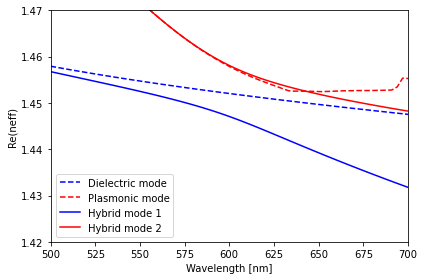

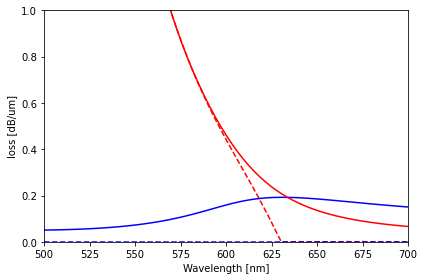

In [76]:

plt.close('all')
plt.figure()
plt.plot(lm_range/1e-9,np.real(neff_0),'--b',label='Dielectric mode')
#plt.plot(lm_range/1e-9,np.real(neff_0_2),'--m',label='Second Dielectric mode')
#plt.plot(lm_range/1e-9,np.real(neff_0_3),'--g',label='Third Dielectric mode')
#plt.plot(lm_range/1e-9,np.real(neff_0_4),'--r',label='Fourth Dielectric mode')
plt.plot(lm_range/1e-9,np.real(neff_s),'--r',label='Plasmonic mode')

plt.plot(lm_range/1e-9,np.real(neff_1),'-b',label='Hybrid mode 1')
plt.plot(lm_range/1e-9,np.real(neff_2),'-r',label='Hybrid mode 2')
#plt.plot(lm_range/1e-9,np.real(neff_3),'-m',label='Hybrid mode 3')
#plt.plot(lm_range/1e-9,np.real(neff_4),'-g',label='Hybrid mode 4')

axes = plt.gca()
axes.set_xlim([500, 700])
axes.set_ylim([1.42, 1.47])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Re(neff)')
plt.legend(loc=3)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(lm_range/1e-9,(20/np.log(10)*np.imag(neff_s)*2*np.pi/lm_range*1e-6),'--r',label='SR-SPP mode')
plt.plot(lm_range/1e-9,(20/np.log(10)*np.imag(neff_0)*2*np.pi/lm_range*1e-6),'--b',label='Core mode')
#plt.plot(lm_range/1e-9,(20/np.log(10)*np.imag(neff_0_2)*2*np.pi/lm_range*1e-6),'--b',label='Second Core mode')
plt.plot(lm_range/1e-9,(20/np.log(10)*np.imag(neff_1)*2*np.pi/lm_range*1e-6),'-b',label='SM 1')
plt.plot(lm_range/1e-9,(20/np.log(10)*np.imag(neff_2)*2*np.pi/lm_range*1e-6),'-r',label='SM 2')
axes = plt.gca()
axes.set_xlim([500, 700])
axes.set_ylim([-0.1, 0.8])
plt.xlabel('Wavelength [nm]')
plt.ylabel('loss [dB/um]')
plt.ylim([0,1])
plt.tight_layout()
plt.show()


#### Plot magnetic field magnitude of modes


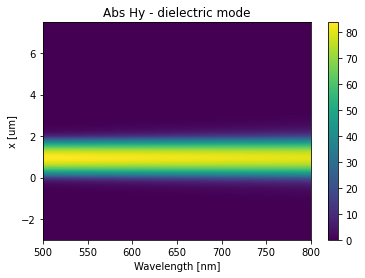

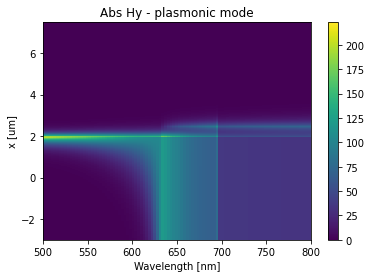

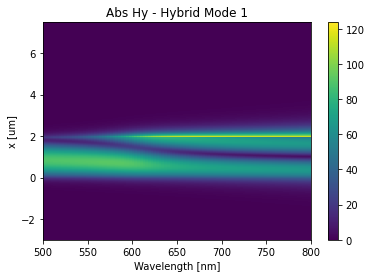

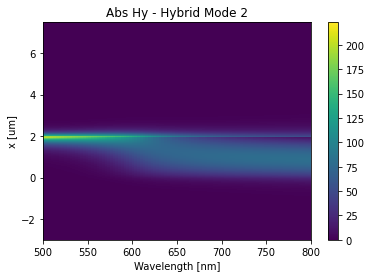

In [77]:
plt.figure()
plt.pcolormesh(LM/1e-9,X/1e-6,np.abs(Hy_0))
plt.xlabel('Wavelength [nm]')
plt.ylabel('x [um]')
plt.title('Abs Hy - dielectric mode')
axes = plt.gca()
plt.colorbar()
plt.show()

plt.figure()
plt.pcolormesh(LM/1e-9,X/1e-6,np.abs(Hy_s))
plt.xlabel('Wavelength [nm]')
plt.ylabel('x [um]')
plt.title('Abs Hy - plasmonic mode')
axes = plt.gca()
plt.colorbar()
plt.show()

plt.figure()
plt.pcolormesh(LM/1e-9,X/1e-6,np.abs(Hy_1))
plt.xlabel('Wavelength [nm]')
plt.ylabel('x [um]')
plt.title('Abs Hy - Hybrid Mode 1')
axes = plt.gca()
plt.colorbar()
plt.show()

plt.figure()
plt.pcolormesh(LM/1e-9,X/1e-6,np.abs(Hy_2))
plt.title('Abs Hy - Hybrid Mode 2')
plt.xlabel('Wavelength [nm]')
plt.ylabel('x [um]')
axes = plt.gca()
plt.colorbar()
plt.show()


#### Plot electric field magnitude of modes


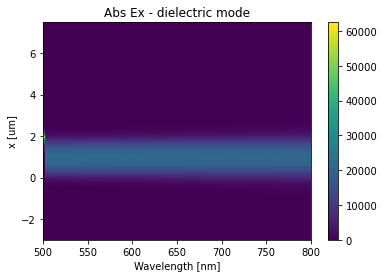

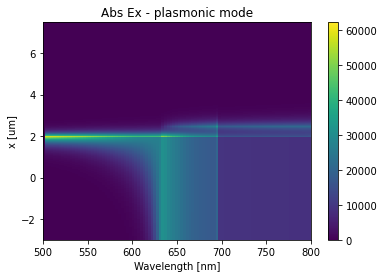

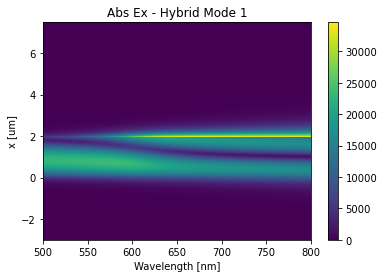

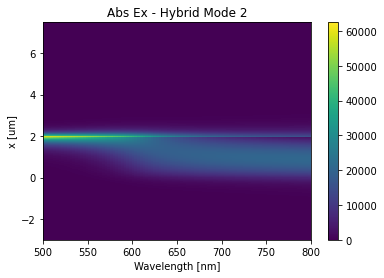

In [78]:
plt.close('all')
plt.figure()
plt.pcolormesh(LM/1e-9,X/1e-6,np.abs(Ex_0))
plt.xlabel('Wavelength [nm]')
plt.ylabel('x [um]')
plt.title('Abs Ex - dielectric mode')
axes = plt.gca()
plt.colorbar()
plt.show()

plt.figure()
plt.pcolormesh(LM/1e-9,X/1e-6,np.abs(Ex_s))
plt.xlabel('Wavelength [nm]')
plt.ylabel('x [um]')
plt.title('Abs Ex - plasmonic mode')
axes = plt.gca()
plt.colorbar()
plt.show()

plt.figure()
plt.pcolormesh(LM/1e-9,X/1e-6,np.abs(Ex_1))
plt.xlabel('Wavelength [nm]')
plt.ylabel('x [um]')
plt.title('Abs Ex - Hybrid Mode 1')
axes = plt.gca()
plt.colorbar()
plt.show()

plt.figure()
plt.pcolormesh(LM/1e-9,X/1e-6,np.abs(Ex_2))
plt.title('Abs Ex - Hybrid Mode 2')
plt.xlabel('Wavelength [nm]')
plt.ylabel('x [um]')
axes = plt.gca()
plt.colorbar()
plt.show()


#### Now we calculate and plot the coefficients, Eq. (8) of the paper
...note that $c_1$ and $c_2$ dominate

**IMPORTANT:**
Because normalization uses unconjugated form and the waveguide includes losses, 
the sum of the coefficients is NOT equal to the total power carried in the waveguide.
These coefficients tell you how to superpose normalized fields in lossy media 
(which, because they're unconjugated, don't necessarily have unity power) to obtain the input at the boundary
(but the input waveguide is lossless, so for the dielectric waveguide, normalization leads to modes with in unity power!)

100.0% complete


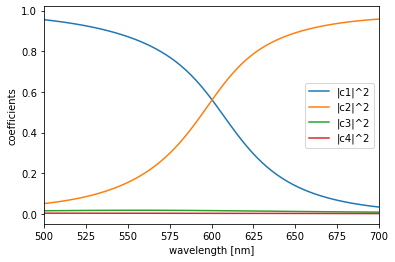

In [79]:
# pre-allocate
c1 = np.zeros(lm_range.shape)+0*1j
c2 = np.zeros(lm_range.shape)+0*1j
c3 = np.zeros(lm_range.shape)+0*1j
c4 = np.zeros(lm_range.shape)+0*1j
Hy_sm = np.zeros(LM.shape)+0*1j
Ex_sm = np.zeros(LM.shape)+0*1j

# go
for kn in range(0,lm_range.size):
    clear_output(wait=True)
    print(f'{float(kn+1)/float(lm_range.size)*100}% complete')

    # project to get the coefficients -  Eq. (8)
    c1[kn]  = 0.5*np.trapz(Ex_1[:,kn]*(-Hy_0[:,kn]),x=x)
    c2[kn]  = 0.5*np.trapz(Ex_2[:,kn]*(-Hy_0[:,kn]),x=x)
    c3[kn]  = 0.5*np.trapz(Ex_3[:,kn]*(-Hy_0[:,kn]),x=x)
    c4[kn]  = 0.5*np.trapz(Ex_4[:,kn]*(-Hy_0[:,kn]),x=x)
    
    # write input fields as superposition of hybrid eigenmode fields -  four-mode version of Eq. (5),(6)
    # note: removing the third and fourth mode (c3=0, c4=0) does not impact the result significantly
    Hy_sm[:,kn] = (c1[kn]*Hy_1[:,kn]+c2[kn]*Hy_2[:,kn] + c3[kn]*Hy_3[:,kn] + c4[kn]*Hy_4[:,kn])
    Ex_sm[:,kn] = (c1[kn]*Ex_1[:,kn]+c2[kn]*Ex_2[:,kn] + c3[kn]*Ex_3[:,kn] + c4[kn]*Ex_4[:,kn])
    
plt.figure()
plt.plot(lm_range/1e-9,np.abs(c1)**2,label='|c1|^2')
plt.plot(lm_range/1e-9,np.abs(c2)**2,label='|c2|^2')
plt.plot(lm_range/1e-9,np.abs(c3)**2,label='|c3|^2')
plt.plot(lm_range/1e-9,np.abs(c4)**2,label='|c4|^2')
plt.xlim([500,700])
plt.legend()
plt.xlabel('wavelength [nm]')
plt.ylabel('coefficients')
plt.show()

#### Pick three lengths and propagate, Eq. (5) and (6) of the paper

Resonances appear


In [80]:
L_range = np.array([25e-6, 37.5e-6, 50e-6])

# output coefficients - since the output depends on length, we need a 2D array..
t0   = np.zeros((len(L_range),len(lm_range)))+0*1j
t0_2 = np.zeros((len(L_range),len(lm_range)))+0*1j
t0_3 = np.zeros((len(L_range),len(lm_range)))+0*1j
t0_4 = np.zeros((len(L_range),len(lm_range)))+0*1j

for kz in range(0,len(L_range)):
    Z = L_range[kz]
    clear_output(wait=True)
    print(f'{float(kz+1)/float(L_range.size)*100}% complete')

    for kn in range(0,lm_range.size):
        # propagate Eigenmodes
        Hy_sm[:,kn] = (c1[kn]*Hy_1[:,kn]*np.exp(1j*neff_1[kn]*Z*2*np.pi/lm_range[kn])+c2[kn]*Hy_2[:,kn]*np.exp(1j*neff_2[kn]*Z*2*np.pi/lm_range[kn]) + c3[kn]*Hy_3[:,kn]*np.exp(1j*neff_3[kn]*Z*2*np.pi/lm_range[kn]) + c4[kn]*Hy_4[:,kn]*np.exp(1j*neff_4[kn]*Z*2*np.pi/lm_range[kn]))
        Ex_sm[:,kn] = (c1[kn]*Ex_1[:,kn]*np.exp(1j*neff_1[kn]*Z*2*np.pi/lm_range[kn])+c2[kn]*Ex_2[:,kn]*np.exp(1j*neff_2[kn]*Z*2*np.pi/lm_range[kn]) + c3[kn]*Ex_3[:,kn]*np.exp(1j*neff_3[kn]*Z*2*np.pi/lm_range[kn]) + c4[kn]*Ex_4[:,kn]*np.exp(1j*neff_4[kn]*Z*2*np.pi/lm_range[kn]))

        # project fields,  transmission coefficients on each mode at the end - Eq. (9)
        t0[kz,kn]  = 0.5*np.trapz(Ex_0[:,kn]*(-Hy_sm[:,kn]),x=x)
        t0_2[kz,kn]  = 0.5*np.trapz(Ex_0_2[:,kn]*(-Hy_sm[:,kn]),x=x)
        t0_3[kz,kn]  = 0.5*np.trapz(Ex_0_3[:,kn]*(-Hy_sm[:,kn]),x=x)
        t0_4[kz,kn]  = 0.5*np.trapz(Ex_0_4[:,kn]*(-Hy_sm[:,kn]),x=x)

# square amplite to get the transmittance into each waveguide mode
# In the purely lossless dielectric waveguide, the normalization is identical to power normalization, 
# and thus the transmitted power in each mode is then given by |t_i|^2

T_0 = abs(t0)**2
T_0_2 = abs(t0_2)**2
T_0_3 = abs(t0_3)**2
T_0_4 = abs(t0_4)**2


100.0% complete


#### Comparison with "simple" approach

calculate the transmission using only Eq. (4) in the paper, at $L = 37.5\mu m$


In [81]:
min_neff_imag = np.zeros(len(neff_1))+0*1j
for ki in range(0,len(neff_1)):
    min_neff_imag[ki] = np.min([np.imag(neff_1[ki]),np.imag(neff_2[ki])])
T_EM = np.exp(-(min_neff_imag)*37.5e-6*2*np.pi/lm_range)

###### Figure 4

Show Eigenmode method only

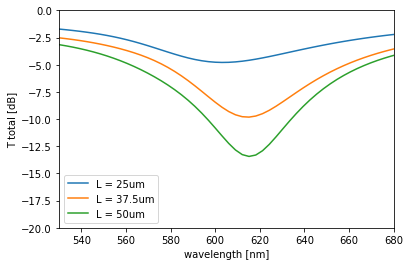

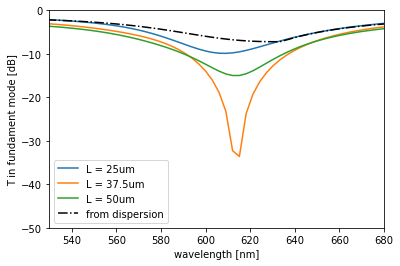

In [82]:
plt.figure()
plt.plot(lm_range/1e-9,10*np.log10(T_0[0,:]+T_0_2[0,:]+T_0_3[0,:]),label = 'L = 25um')
plt.plot(lm_range/1e-9,10*np.log10(T_0[1,:]+T_0_2[1,:]+T_0_3[1,:]),label = 'L = 37.5um')
plt.plot(lm_range/1e-9,10*np.log10(T_0[2,:]+T_0_2[2,:]+T_0_3[2,:]),label = 'L = 50um')
plt.xlim([530,680])
plt.ylim([-20,0])
plt.xlabel('wavelength [nm]')
plt.ylabel('T total [dB]')
plt.legend(loc=3)
plt.show() 

plt.figure()
plt.plot(lm_range/1e-9,10*np.log10(T_0[0,:]),label = 'L = 25um')
plt.plot(lm_range/1e-9,10*np.log10(T_0[1,:]),label = 'L = 37.5um')
plt.plot(lm_range/1e-9,10*np.log10(T_0[2,:]),label = 'L = 50um')
plt.plot(lm_range/1e-9,10*np.log10(np.abs(T_EM)**2),'-.k',label = 'from dispersion')
plt.xlim([530,680])
plt.ylim([-50,0])
plt.xlabel('wavelength [nm]')
plt.ylabel('T in fundament mode [dB]')
plt.legend()
plt.show()

###### Figure 4

Show comparison with COMSOL

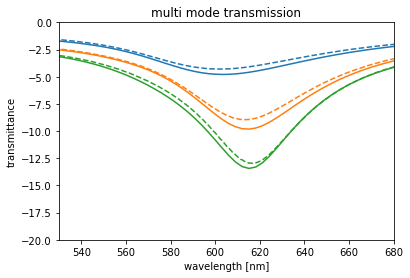

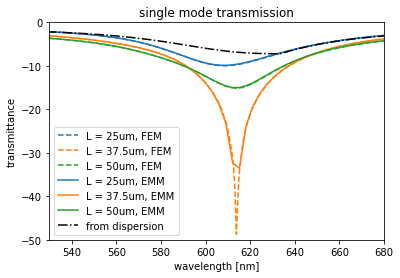

In [83]:
# load comsol results and compare

temp = sio.loadmat(str(n_analyte)+'_comsol_github.mat')

lm_comsol = temp['lm'][0]

# single mode power at output
T_comsol_sm_1 = temp['T_singlemode'][0,:]
T_comsol_sm_2 = temp['T_singlemode'][1,:]
T_comsol_sm_3 = temp['T_singlemode'][2,:]

# total power at output
T_comsol_mm_1 = temp['T_multimode'][0,:]
T_comsol_mm_2 = temp['T_multimode'][1,:]
T_comsol_mm_3 = temp['T_multimode'][2,:]

plt.figure()
# plot COMSOL as a dotted line
plt.plot(lm_comsol/1e-9,10*np.log10((T_comsol_mm_1)),'--')
plt.plot(lm_comsol/1e-9,10*np.log10((T_comsol_mm_2)),'--')
plt.plot(lm_comsol/1e-9,10*np.log10((T_comsol_mm_3)),'--')
plt.gca().set_prop_cycle(None)
plt.plot(lm_range/1e-9,10*np.log10(T_0[0,:]+T_0_2[0,:]+T_0_3[0,:]))
plt.plot(lm_range/1e-9,10*np.log10(T_0[1,:]+T_0_2[1,:]+T_0_3[1,:]))
plt.plot(lm_range/1e-9,10*np.log10(T_0[2,:]+T_0_2[2,:]+T_0_3[2,:]))
plt.xlim([530,680])
plt.ylim([-20,0])
plt.title('multi mode transmission')
plt.xlabel('wavelength [nm]')
plt.ylabel('transmittance')
plt.show() 

plt.figure()
plt.plot(lm_comsol/1e-9,10*np.log10((T_comsol_sm_1)),'--',label = 'L = 25um, FEM')
plt.plot(lm_comsol/1e-9,10*np.log10((T_comsol_sm_2)),'--',label = 'L = 37.5um, FEM')
plt.plot(lm_comsol/1e-9,10*np.log10((T_comsol_sm_3)),'--',label = 'L = 50um, FEM')
plt.gca().set_prop_cycle(None)
plt.plot(lm_range/1e-9,10*np.log10(T_0[0,:]),label = 'L = 25um, EMM')
plt.plot(lm_range/1e-9,10*np.log10(T_0[1,:]),label = 'L = 37.5um, EMM')
plt.plot(lm_range/1e-9,10*np.log10(T_0[2,:]),label = 'L = 50um, EMM')
plt.plot(lm_range/1e-9,10*np.log10(np.abs(T_EM)**2),'-.k',label = 'from dispersion')
plt.xlim([530,680])
plt.ylim([-50,0])
plt.title('single mode transmission')
plt.xlabel('wavelength [nm]')
plt.ylabel('transmittance')
plt.legend()
plt.show()

In [84]:
if n_analyte==1.36:
    lm_select = 610e-9

if n_analyte==1.32:
    lm_select = 560e-9

lm_in =np.where(np.abs(lm_range-lm_select)==min(np.abs(lm_range-lm_select)))
lm_range[int(lm_in[0])]

# propagate over 50um length...
z = np.linspace(0,50e-6,500)
Z, X = np.meshgrid(z,x)

HYP = np.zeros(X.shape)+0*1j
EXP = np.zeros(X.shape)+0*1j

for kn in range(0,z.size):
    clear_output(wait=True)
    print(f'{float(kn+1)/float(z.size)*100}% complete')
    HYP[:,kn] = np.squeeze((c1[lm_in]*Hy_1[:,lm_in]*np.exp(1j*neff_1[lm_in]*2*np.pi/lm_range[lm_in]*z[kn])+c2[lm_in]*Hy_2[:,lm_in]*np.exp(1j*neff_2[lm_in]*2*np.pi/lm_range[lm_in]*z[kn]) +c3[lm_in]*Hy_3[:,lm_in]*np.exp(1j*neff_3[lm_in]*2*np.pi/lm_range[lm_in]*z[kn]) +c4[lm_in]*Hy_4[:,lm_in]*np.exp(1j*neff_4[lm_in]*2*np.pi/lm_range[lm_in]*z[kn])))
    EXP[:,kn] = np.squeeze((c1[lm_in]*Ex_1[:,lm_in]*np.exp(1j*neff_1[lm_in]*2*np.pi/lm_range[lm_in]*z[kn])+c2[lm_in]*Ex_2[:,lm_in]*np.exp(1j*neff_2[lm_in]*2*np.pi/lm_range[lm_in]*z[kn]) +c3[lm_in]*Ex_3[:,lm_in]*np.exp(1j*neff_3[lm_in]*2*np.pi/lm_range[lm_in]*z[kn]) +c4[lm_in]*Ex_4[:,lm_in]*np.exp(1j*neff_4[lm_in]*2*np.pi/lm_range[lm_in]*z[kn])))

100.0% complete


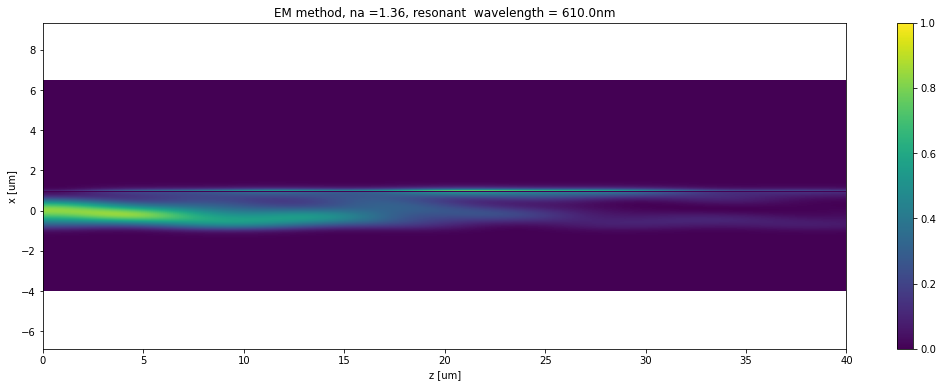

In [85]:
plt.figure(figsize=(18, 6))
plt.pcolormesh(Z/1e-6,X/1e-6-1,np.real((-np.conj(HYP)*(EXP)))/np.max(np.real((-np.conj(HYP)*(EXP)))))
axes = plt.gca()
axes.set_ylim([-2.5, 2.5])
plt.colorbar()
plt.xlabel('z [um]')
plt.ylabel('x [um]')
plt.title('EM method, na =' + str(n_analyte) + ', resonant  wavelength = ' + str(lm_select/1e-9) + 'nm' )
plt.clim([0, 1])
plt.axis('equal')
axes.set_xlim([0, 40])
plt.show()

